# Setup

Scipy offers a relatively simple and fast optimizer that can be easily used for pure MLE.

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import random
import scipy
from scipy.optimize import minimize
from scipy.stats import kstest

datapath =  '/'.join(os.getcwd().split("\\")[:-1])+"/0_Auxiliary_Tools/"

# Unidimensional Hawkes MLE

We can easily compute the conditional likelihood of a Hawkes process by treating the history of the process up to each event as independent and exogenous. An overview of the simple and desirable properties of this estimator is offered by Ozaki (1979). 

Let $t_j$ be the time of the j-th event and $H_j$ be the history up to $t_j$. Assume the period of observation of the data goes from $t_0=0$ to the horizon $T>t_J$. The likelihood function of the process $Y = \{t_j\}_{j\geq1}$ can be written as:

$
L(Y) = \left[\prod_{j\geq1} f(t_j-t_{j-1}|H_j)\right]*(1-F(T-t_J|H_J)) = \left[\prod_{j\geq1} \lambda(t_j|H_j)exp\{-\int_{t_{j-1}}^{t_j}\lambda(\tau|H_j)d\tau\}\right]*exp\{-\int_{t_{J}}^{T}\lambda(\tau|H_j)d\tau\}
$

$
ll(Y) = log(L(Y)) = \sum_{j\geq1} log(\lambda(t_j|H_j)) -\int_{t_0}^{T}\lambda(\tau|H_\tau)d\tau
$

This function for $ll(Y)$ is in general easy and tractable. Since integrability is a desirable property from kernels for Hawkes process for a variety of other properties, it is commonly trivial to reduce $\int_{t_0}^{T}\lambda(\tau|H_\tau)d\tau$ to a closed form expression. Furthermore, we can use a variety of tricks to ensure that $\lambda(t_j|H_j)$ does not lead to numerical errors. Specifically, since we rarely use non-additive forms for $\lambda(.)$, we can factor out potentially problematic terms using log-sum approximations.

As an example, we can fit an MLE estimate to one of the simulated process in "Unidi_Sample.csv". First, sample a random process:

Actual parameters:  [0.01594534695137684, 0.607360053396184]


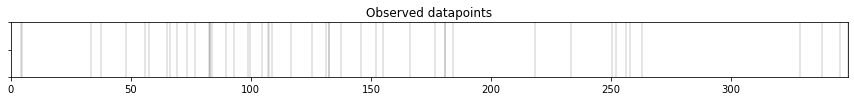

In [100]:
T = 360
dataframe = pd.read_csv(datapath + "Unidi_Sample.csv",index_col=0)
sample_process = dataframe.sample(1)
print("Actual parameters: ",sample_process["Params"][0])
timing_string = sample_process["Observations"][0].split(" ")[1:-1]
timing_string =[time.strip().strip('') for time in timing_string]
timeseries = np.array([float(k) for k in list(filter(None,timing_string))])
fig, ax = plt.subplots(nrows=1,figsize=(15, 1))
ax.set_yticklabels([])
ax.set_xlim(xmin=0,xmax=timeseries[-1])
for xc in zip(timeseries):
    ax.axvline(x=xc,c='black',linewidth=0.2)
ax.set_title('Observed datapoints')
plt.show()

For simplicity, let's assume the standard exponential kernel is a good fit to the data (in this case, it is exactly correct). In real applications, the most kernels can produce realistic approximations of the observed patterns. We cannot, however, make the same assumption about our choice of base rate. For starters we can assume that the base rate is constant (it is not) and check how that biases our estimates.

These are our necessary and sufficient auxiliary functions: 

In [291]:
def ll(T,Y,baseline,kernel):
    safety = 1e-9
    h = baseline.density(Y) + kernel.density(Y,Y)
    H = baseline.cumulative(T,Y) + kernel.cumulative(T,Y)
    ll = np.sum(np.log(safety + h)) - H
    return ll

class exp_kernel:
    def __init__(self,params):
        self.α = params[0]
        self.β = params[1]
        
    def density(self,t,history):
        history_deltas = t.reshape(-1,1) - history
        timing_mask = history_deltas>0
        raw = self.α*np.exp(-self.β*(history_deltas*timing_mask))
        return np.sum(raw*timing_mask,1)
    
    def cumulative(self,T,history):
        return np.sum((self.α/self.β)*(1-np.exp(-self.β*(T-history))))
    
    def cumulative_intervals(self,t0,t1,history):
        return np.sum((self.α/self.β)*(np.exp(-self.β*(t0-history))-np.exp(-self.β*(t1-history))))
    
class constant_baseline:
    def __init__(self,mu):
        self.mu = mu
    
    def density(self,t):
        return self.mu*np.ones(t.reshape(-1,1).shape[0])
    
    def cumulative(self,T,t):
        return self.mu*T

And this is a simple estimation loop based on scipy's optimizer:

In [289]:
def simple_cost(params):
    baseline = constant_baseline(params[0])
    kernel = exp_kernel(params[1:])
    return -ll(360,timeseries,baseline,kernel)

starting_params = [1e-1,1e-3,1e-2]
# set bounds (all parameters in this formulation must be positive)
bnds=((1e-5,np.inf),(0,np.inf),(0,np.inf))

optimizer = minimize(simple_cost, [starting_params],method='L-BFGS-B',bounds=bnds)
print("Estimated kernel parameters: ", optimizer.x[1:])
print("Actual parameters:           ", sample_process["Params"][0])

Estimated kernel parameters:  [0.03043337 0.0572034 ]
Actual parameters:            [0.01594534695137684, 0.607360053396184]


Using a flat base rate in general leads to overestimating both the size and duration of endogenous feedback. 

We can also visualize the inferred intensity function over $t$ under the estimated parameters. Graphically, the inferred intensity should look similar to the actual intensity plot generated when we first simulated this dataset. There is, however, an underlying chronological mistake in this estimate: originally, the increase in event counts is caused by an increase in intensity; meanwhile, in our estimate the intensity rate is fairly low until enough subsequent events have accumulated feedback shocks to increase it. That is, while we capture that there is a period of higher intensity, our model also estimates that the start of that period hinges on an unlikely sequence of events.

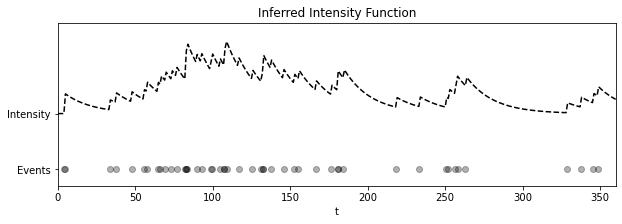

In [253]:
timesteps = np.linspace(0, T, T+1)

pred_intensity = constant_baseline(optimizer.x[0]).density(timesteps) + exp_kernel(optimizer.x[1:]).density(timesteps,timeseries)

fig, ax = plt.subplots(nrows=1,figsize=(10, 3))
ax.set_xlim(xmin=0,xmax=T)
ax.set_ylim(ymin=-0.15,ymax=1.2*(max(pred_intensity)))
ax.scatter(timeseries,np.zeros(len(timeseries))-0.1, color = "black", alpha=0.3)
ax.plot(timesteps,pred_intensity,color="black",linestyle='--')
ax.set_xlabel("t")
ax.set_yticks([-0.1,pred_intensity[0]])
ax.set_yticklabels(["Events","Intensity"])
ax.set_title("Inferred Intensity Function")
plt.show()

# Quality-of-fit assessment

We can benchmark our model alternatives using usual statistical techniques (AIC, BIC, LL ratios, etc), but we also have absolute metrics for quality of fit that are point-process-specific.

First, and usually most important, we can capture shortcomings of our baseline intensity function by investigating the cumulative residual intensity of the process.

By the definition of a point process, the expected number of events in an interval $[0,t]$ is $\Lambda(t)=\int_0^{t}\lambda(\tau)d\tau$. Define the cumulative residual intensity as $R(t)=\Lambda(t)-\sum_j 1_{\{t_j\leq t\}}$. We can look for systematic deviations from the true process in our estimates by plotting $R(t)$ over a grid of the observation period (exactly as you'd investigate other timeseries residuals). For instance, below we can see that our estimate has consistently failed to capture the higher rate of events in the first half of the process.

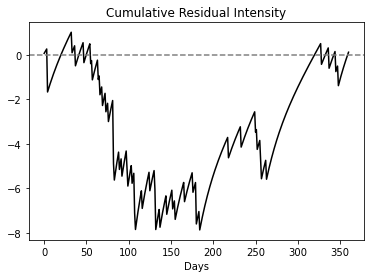

In [283]:
event_counts = np.zeros(T+1)
for t in range(T+1):
    event_counts[t] += np.sum((t<timeseries)&(timeseries<(t+1)))
    
plt.plot(np.cumsum(pred_intensity - event_counts),color='black')
plt.axhline(0,linestyle='--',color='grey')
plt.title("Cumulative Residual Intensity")
plt.xlabel("Days")
plt.show()

The residual plot mostly captures failures to account for the base rate, but we also need an alternative diagnostic for the endogenous feedback loop. One tool for this is analyzing autocorrelation in the transform time distribution (Ogata, 1988; Fox et al., 2016).

The initial idea for this method is the same as in the previous: if the model fits well, we should find that $\Lambda(t) = E\left[\sum_j 1_{\{t_j\leq t\}}\right]$. In equivalente point process terms, if the model fits well, we should find that the set of transform times $\{\Lambda(t_j)\}_j$ follows a Poisson process with rate 1 (a counterintuitive but mathematically correct statement). An even more counterintuitive - and nonetheless direct - implication of that statement is that under a correct model $\Lambda(t_{j+1})-\Lambda(t_j)$ are i.i.d $Exp(1)$, and using the CDF transform we have that $U_j = CDF_{exp}(\Lambda(t_{j+1})-\Lambda(t_j))$ are i.i.d Uniform$_{[0,1]}$.

Verifying that $U_j\sim U([0,1])$ is similar to the previous test, but we can nonetheless get a methodologically sound p-value for how badly we fit the data by using the Kolmogorov-Smirnov test. Successfully achieving the independence part of i.i.d. hinges mostlly on choosing an appropriate endogenous kernel. A simple visual test for independence is to construct a scatterplot of $U_j$ versus $U_{j+1}$ - again, if we are looking at points spread over points and planes we are in familiar point process territory. If the distribution of points in the scatterplot looks more or less uniform, we can claim our model does a passable job at capturing independece. If points are visibly denser anywhere, we should investigate alternative kernels.

First, let's examine what happens when we completely ignore the kernel effects


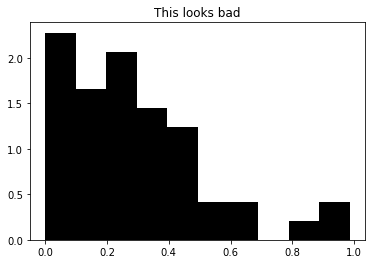

Test how close we are to uniform (null hypothesis: it is uniform)
KstestResult(statistic=0.38397792400029385, pvalue=5.214475187125595e-07)


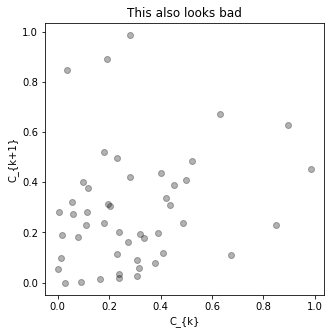

Now consider the performance of our complete Hawkes estimate


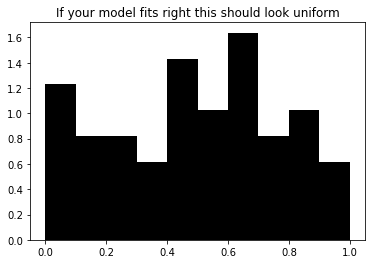

Test how close we are to uniform (null hypothesis: it is uniform)
KstestResult(statistic=0.09194750143724606, pvalue=0.7674192530948764)


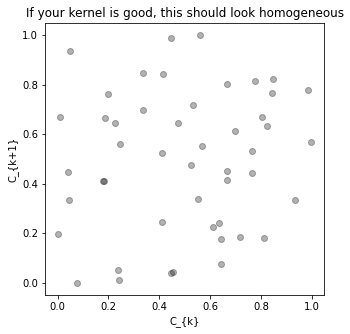

In [353]:
print("First, let's examine what happens when we completely ignore the kernel effects")

# find the transform times
transform_times = np.zeros(len(timeseries))
baseline = constant_baseline(optimizer.x[0])
kernel = exp_kernel(optimizer.x[1:])
for t in range(len(transform_times)):
    transform_times[t] += baseline.cumulative(timeseries[t],0) 
transform_times[1:]-=transform_times[:-1]

# get the transform time CDFs 
C = 1-np.exp(-(transform_times))
plt.hist(C,color="black",density=True)
plt.title("This looks bad")
plt.show()

# test how close C is to Unif[0,1] using Kolmogorov-Smirnov test
print("Test how close we are to uniform (null hypothesis: it is uniform)")
print(kstest(C,scipy.stats.uniform.cdf))

# plot C_{k} vs C_{k+1} to see if there's unaccounted for endogeneity 
fig, ax = plt.subplots(nrows=1,figsize=(5,5))
ax.scatter(C[:-1],C[1:],color="black",alpha=0.3)
ax.set_ylabel("C_{k+1}")
ax.set_xlabel("C_{k}")
ax.set_title("This also looks bad")
plt.show()

print("Now consider the performance of our complete Hawkes estimate")

# find the transform times tau
transform_times = np.zeros(len(timeseries))
baseline = constant_baseline(optimizer.x[0])
kernel = exp_kernel(optimizer.x[1:])
for t in range(len(transform_times)):
    transform_times[t] += baseline.cumulative(timeseries[t],0) + kernel.cumulative(timeseries[t],timeseries[:t])
transform_times[1:]-=transform_times[:-1]

# get the transform time CDFs 
C = 1-np.exp(-(transform_times))
plt.hist(C,color="black",density=True)
plt.title("If your model fits right this should look uniform")
plt.show()

# test how close C is to Unif[0,1] using Kolmogorov-Smirnov test
print("Test how close we are to uniform (null hypothesis: it is uniform)")
print(kstest(C,scipy.stats.uniform.cdf))

# plot C_{k} vs C_{k+1} to see if there's unaccounted for endogeneity 
fig, ax = plt.subplots(nrows=1,figsize=(5,5))
ax.scatter(C[:-1],C[1:],color="black",alpha=0.3)
ax.set_ylabel("C_{k+1}")
ax.set_xlabel("C_{k}")
ax.set_title("If your kernel is good, this should look homogeneous")
plt.show()

# Bibliography

Ozaki, T. (1979). Maximum likelihood estimation of Hawkes’ self-exciting point processes. Annals of the Institute of Statistical Mathematics, 31(1), 145–155. https://doi.org/10.1007/BF02480272

Ogata, Y. (1988). Statistical Models for Earthquake Occurrences and Residual Analysis for Point Processes. Journal of the American Statistical Association, 83(401), 9–27. https://doi.org/10.2307/2288914


Fox, E. W., Short, M. B., Schoenberg, F. P., Coronges, K. D., & Bertozzi, A. L. (2016). Modeling E-mail Networks and Inferring Leadership Using Self-Exciting Point Processes. Journal of the American Statistical Association, 111(514), 564–584. https://doi.org/10.1080/01621459.2015.1135802
